In [71]:
import pandas as pd
import numpy as np

from sklearn import ensemble

#Load our two Data Frames
AmesDummies = pd.read_csv('AmesDummies.csv')
AmesDummiesOrdinal = pd.read_csv('AmesDummiesOrdinal.csv')

In [72]:
randomForest = ensemble.RandomForestRegressor(n_estimators=1000)

In [73]:
#Load the Forward Selection DF, which contains the list of Features to include in the linear model:
AmesFeatureDF = pd.read_csv('AmesDummiesForwardAICList.csv')

In [74]:
#Trim AmesDummiesOrdinal to a DF containing only the selected Features:
AmesDF = pd.concat([AmesDummiesOrdinal[list(AmesFeatureDF['CreatedFeatures'])],AmesDummiesOrdinal[['SalePrice']]], axis=1)

In [75]:
#Transform AmesDF into the Train AmesDF
np.random.seed(19)
testIdxes = np.random.choice(range(1458), size=292, replace=False)
trainIdxes = list(set(range(1458))-set(testIdxes))

AmesDF2 = AmesDF.copy()
AmesDF = AmesDF.iloc[trainIdxes,]
AmesDFTest = AmesDF2.iloc[testIdxes,]

In [76]:
#Reset indices of AmesDF
AmesDF.index = range(1166)

In [77]:
#Initiate K-fold (n=5) cross-validation model to train/test:

import sklearn.model_selection as ms
ms_k5 = ms.KFold(n_splits=5, shuffle=True)

In [78]:
#Perform separate train/test validation runs for each of the 5 K-fold groups:

#Create X and Y variables
X = AmesDF.drop('SalePrice', axis=1)
Y = AmesDF['SalePrice']

testX = AmesDFTest.drop('SalePrice', axis=1)
testY = AmesDFTest['SalePrice']

#Instantiate the K-fold generator object:
np.random.seed(0)
AmesDF5Fold = ms_k5.split(AmesDF.drop('SalePrice', axis=1), AmesDF['SalePrice'])

#Produce list of test R^2 scores, and Actual vs Predicted lists for the individual runs
R2List = []
PredictList = []
ActualList = []
PureTestR2 = []
RMSLE = []

for train, test in AmesDF5Fold:
    randomForest.fit(X.iloc[train,], Y[train])
    p = randomForest.predict(X.iloc[test,])
    R2 = randomForest.score(X.iloc[test,], Y[test])
    TestR2 = randomForest.score(testX, testY)
    R2List.append(R2)
    PureTestR2.append(TestR2)
    PredictList.append(p)
    ActualList.append(Y[test])
    PredictionsTest = randomForest.predict(testX)
    RMSLEvalue = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(PredictionsTest), 2)))
    RMSLE.append(RMSLEvalue)
    

In [79]:
#What are the R^2 values for our runs?
print(R2List)
print(PureTestR2)
print(RMSLE)

[0.8583923436640601, 0.8912499448078207, 0.9157428273189788, 0.8597948365515857, 0.8784493526567935]
[0.8818210615376865, 0.8854690536579339, 0.8833290421172749, 0.8905677785252308, 0.8830591135134988]
[0.14262333400009947, 0.14067344705999812, 0.1367536802720192, 0.13786879222305892, 0.1397440291044773]


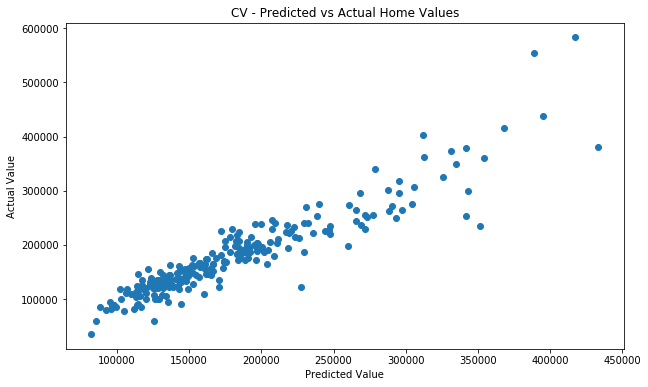

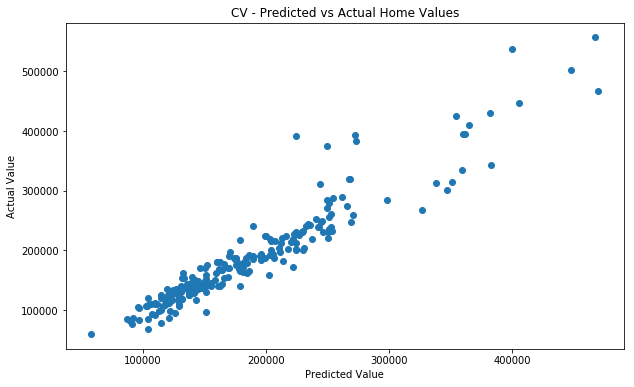

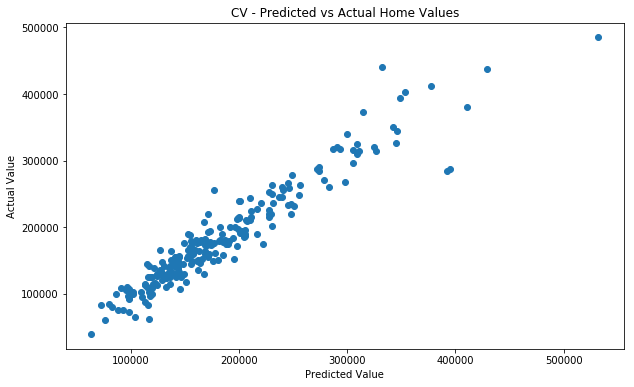

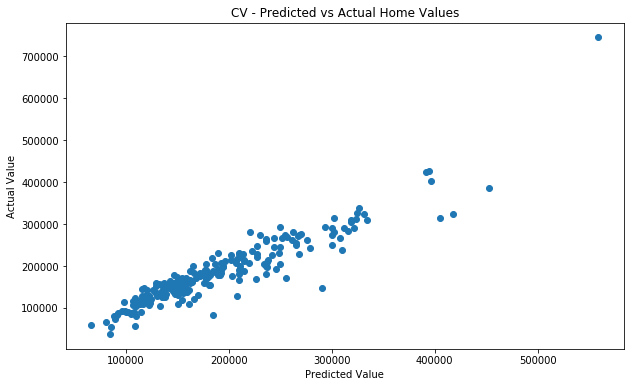

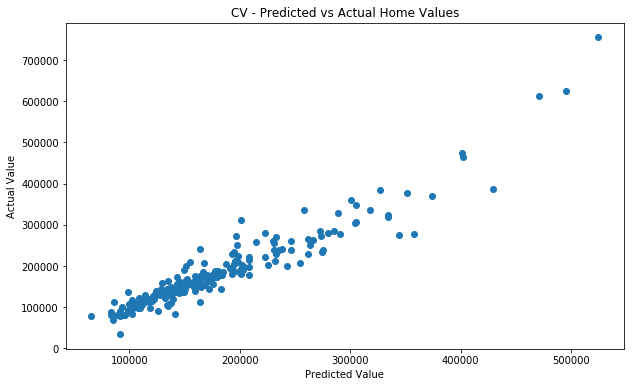

In [52]:
#Plot the predicted vs actual 'SalePrice' values for each of the 5 runs:
import matplotlib.pyplot as plt

for i in range(len(PredictList)):

    plt.figure(figsize=(10,6))
    plt.scatter(PredictList[i], ActualList[i])
    plt.xlabel('Predicted Value')
    plt.ylabel('Actual Value')
    plt.title('CV - Predicted vs Actual Home Values')   
    plt.show()

In [56]:
#As we did in the lienar model, what would this look like for only 2 folds (50/50 split between groups?)
ms_k2 = ms.KFold(n_splits=2, shuffle=True)

#Perform separate train/test validation runs for each of the 5 K-fold groups:

#Create X and Y variables
X = AmesDF.drop('SalePrice', axis=1)
Y = AmesDF['SalePrice']

testX = AmesDFTest.drop('SalePrice', axis=1)
testY = AmesDFTest['SalePrice']

#Instantiate the K-fold generator object:
np.random.seed(0)
AmesDF2Fold = ms_k2.split(AmesDF.drop('SalePrice', axis=1), AmesDF['SalePrice'])

#Produce list of test R^2 scores, and Actual vs Predicted lists for the individual runs
R2ListN2 = []
PredictListN2 = []
ActualListN2 = []
PureTestR2N2 = []
RMSLE = []

for train, test in AmesDF2Fold:
    randomForest.fit(X.iloc[train,], Y[train])
    p = randomForest.predict(X.iloc[test,])
    R2 = randomForest.score(X.iloc[test,], Y[test])
    TestR2 = randomForest.score(testX, testY)
    R2ListN2.append(R2)
    PureTestR2N2.append(TestR2)
    PredictListN2.append(p)
    ActualListN2.append(Y[test])
    PredictionsTest = randomForest.predict(testX)
    RMSLEvalue = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(PredictionsTest), 2)))
    RMSLE.append(RMSLEvalue)

In [57]:
#What are the R^2 scores for each of our 2 runs? Still a fairly good 79% and 86% R^2 value.
print(R2ListN2)
print(PureTestR2N2)
print(RMSLE)

[0.8589205652146605, 0.8567232651656096]
[0.8792763155106378, 0.8821781796083062]
[0.14405783849777634, 0.14205170126257177]


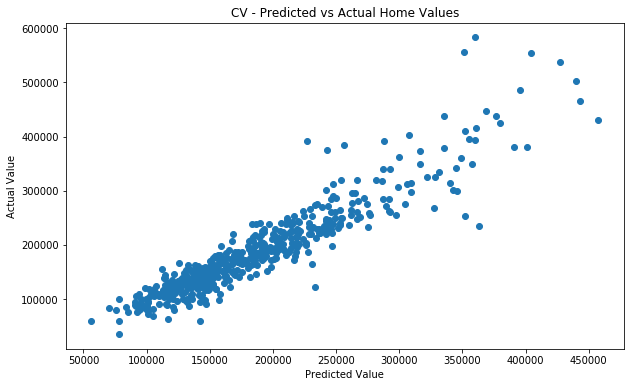

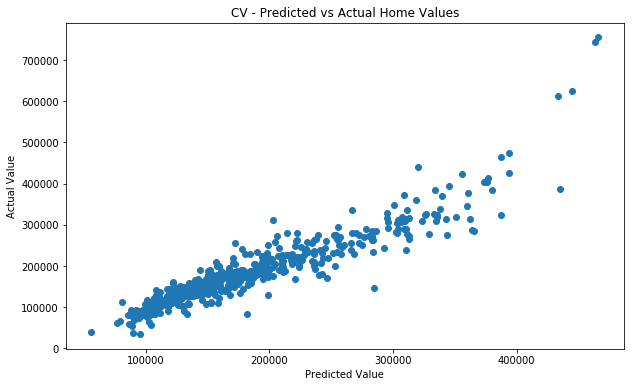

In [55]:
#Let's plot these:
for i in range(len(PredictListN2)):

    plt.figure(figsize=(10,6))
    plt.scatter(PredictListN2[i], ActualListN2[i])
    plt.xlabel('Predicted Value')
    plt.ylabel('Actual Value')
    plt.title('CV - Predicted vs Actual Home Values')
    plt.show()